<a href="https://colab.research.google.com/github/qmeng222/CNN/blob/main/CNN/classify_Gaussian_blurs_featureMaps_softcoded.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mission:

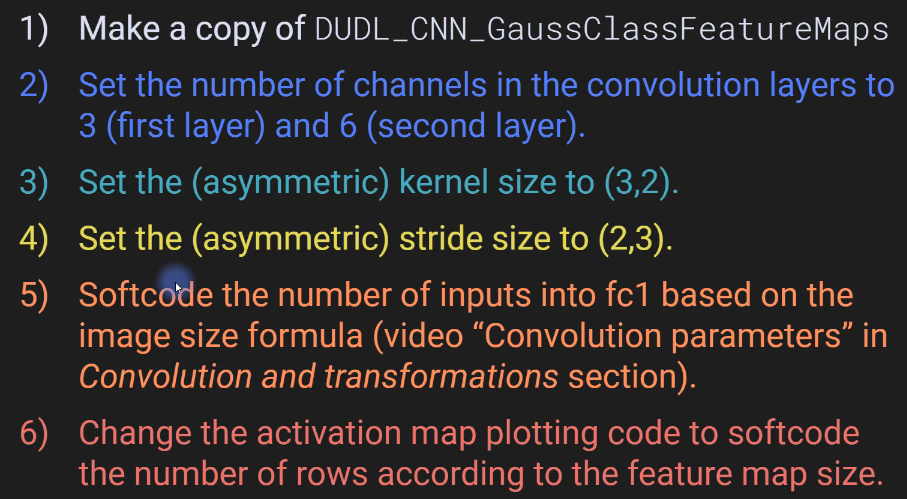

# 2D Gaussian:

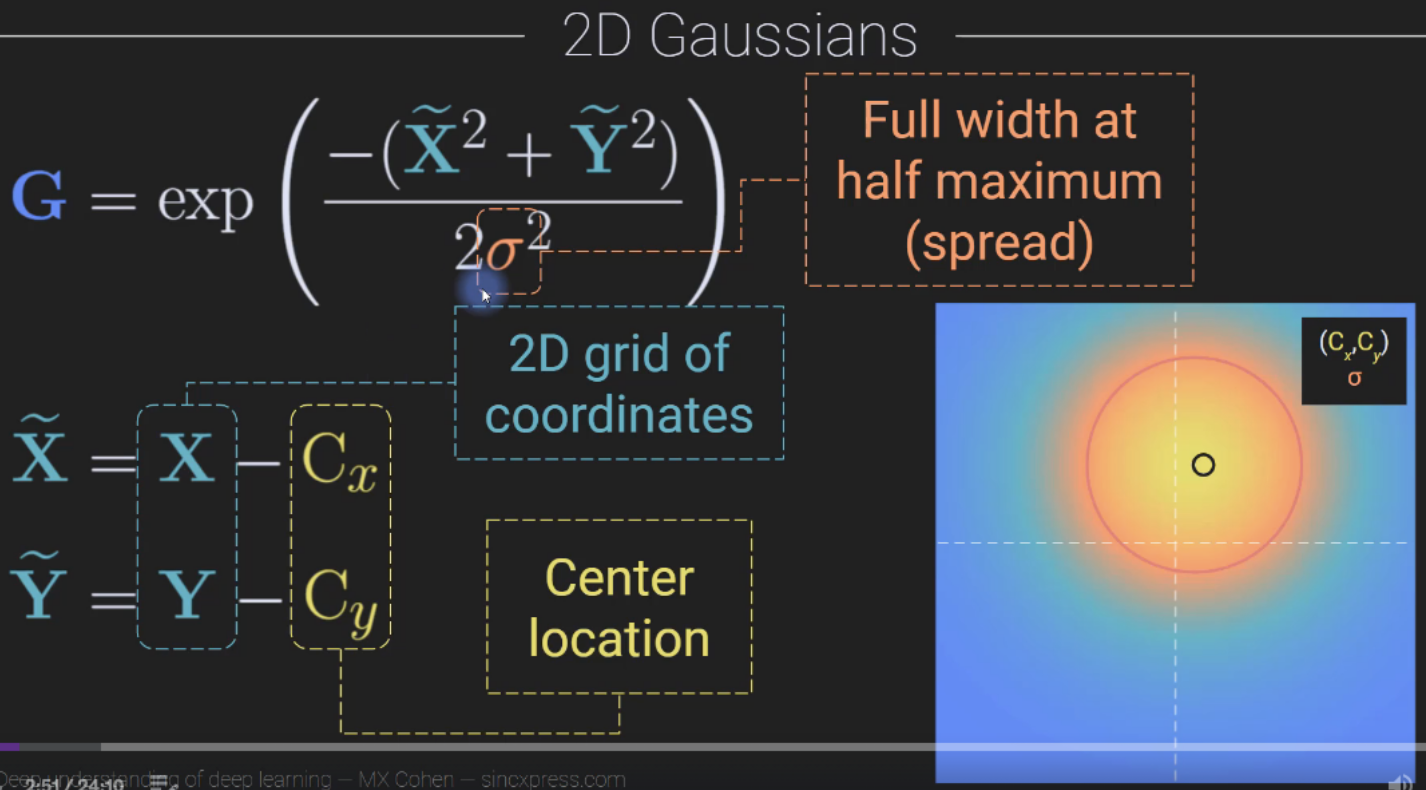

In [43]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

from torchsummary import summary # provide summary info about the total count of parameters in the model

import matplotlib.pyplot as plt
import matplotlib_inline as inl
inl.backend_inline.set_matplotlib_formats("svg")

In [44]:
# create Gaussian blurs with different widths:

nPerClass = 1000 # 1000 imgs for each category
imgSize   = 91   # 91x91 pixels

x = np.linspace(-4,4,imgSize) # [-4., ..., 4.], 91 elements in total
X,Y = np.meshgrid(x,x)
# tmp = np.meshgrid(x,x) # coordinate grid from the arrays `x` and `x`
# print(tmp, "\n") # `tmp` is a list of 2 elements, each elmt is a 91x91 matrix
# X, Y = tmp[0], tmp[1]
print(X.shape) # (91, 91)
print(Y.shape, "\n") # (91, 91)

# two different widths (arbitrary units) -> sigma:
widths = [1.8, 2.4]

# initialize images and labels:
images = torch.zeros(2*nPerClass,1,imgSize,imgSize) # grayscale
labels = torch.zeros(2*nPerClass)

for i in range(2*nPerClass):
  # generates random centers, sampled from a normal distribution with a mean of 0 and a standard deviation of 2
  ro = 2*np.random.randn(2) # ro: random offset, each `ro` is row vector with shape (2, )

  # Guassian:
  G  = np.exp( -( (X-ro[0])**2 + (Y-ro[1])**2) / (2*widths[i%2]**2) ) # `i%2` returns the remainder after division (alternate between 0 and 1) -> choose 1.8 and 2.4 alternatively

  # add noise: 2D array filled with random numbers sampled from a standard normal distribution with a mean of 0 and standard deviation of 1
  G  = G + np.random.randn(imgSize,imgSize)/5 # each G shape (91, 91)

  # (91, 91) np array -> (1, 91, 91) torch tensor
  images[i,:,:,:] = torch.Tensor(G).view(1,imgSize,imgSize)
  labels[i] = i%2 # [0., 1., 0.,  ..., 1., 0., 1.]

# labels 1D vector to 2D matrix, because CNN only takes matrix:
print(labels.shape) # torch.Size([2000])
labels = labels[:,None] # vector -> matrix, because CNN only takes matrix
print(labels.shape) # torch.Size([2000, 1])

(91, 91)
(91, 91) 

torch.Size([2000])
torch.Size([2000, 1])


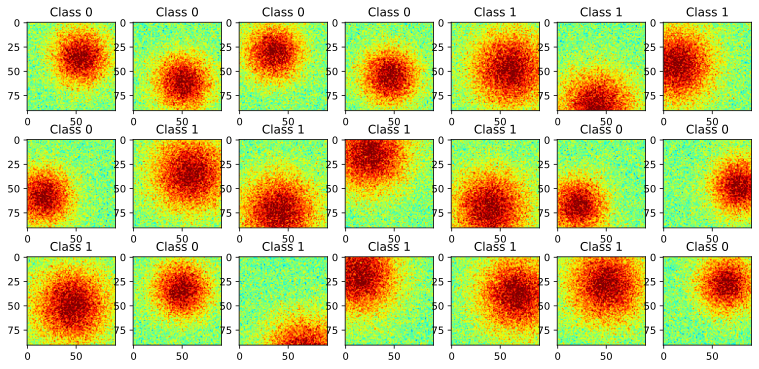

In [45]:
# visualize some images:

fig,axs = plt.subplots(3,7,figsize=(13,6))

for i,ax in enumerate(axs.flatten()):
  whichpic = np.random.randint(2*nPerClass)
  G = np.squeeze( images[whichpic,:,:] )
  ax.imshow(G,vmin=-1,vmax=1,cmap='jet')
  ax.set_title('Class %s'%int(labels[whichpic].item()))
  # ax.set_xticks([])
  # ax.set_yticks([])

plt.show()

In [46]:
# use scikitlearn to split the data (torch tensor)
train_data,test_data, train_labels,test_labels = train_test_split(images, labels, test_size=.1)

# torch tensor -> torch Dataset obj
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# torch Dataset obj -> torch DataLoader obj
batchsize    = 32 # 32 samples in each minibatch
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [47]:
# check size (imgs x channels x W x H
print( train_loader.dataset.tensors[0].shape ) # images
print( train_loader.dataset.tensors[1].shape ) # labels

torch.Size([1800, 1, 91, 91])
torch.Size([1800, 1])


In [48]:
# function to build the model and create a model instance:
def makeTheNet():

  # create a class for the model
  class gausnet(nn.Module):
    def __init__(self):
      super().__init__()

      # soft-coded variables
      k = (3,2) # asymmetric kernel size
      s = (2,3) # asymmetric stride size

      # conv1 with 2D parameters (W, H)
      self.conv1 = nn.Conv2d(1,3,k,s) # (inChans, outChans, k, s=1, p=0)

      imsizeW = np.floor( (91+2*self.conv1.padding[0]-k[0])/s[0] ) + 1 # convolution layer
      imsizeW = np.floor( imsizeW/2 ) # pooling layer, 2 is the pooling window (spatial extent for max pooling)

      imsizeH = np.floor( (91+2*self.conv1.padding[1]-k[1])/s[1] ) + 1 # convolution layer
      imsizeH = np.floor( imsizeH/2 ) # pooling layer, 2 is the spatial extent for max pooling

      # conv2 with 2D parameters (W, H)
      self.conv2 = nn.Conv2d(3,6,k,s) # (inChans, outChans, k, s=1, p=0)

      imsizeW = np.floor( (imsizeW+2*self.conv1.padding[0]-k[0])/s[0] ) + 1 # conv layer
      imsizeW = int( imsizeW/2 ) # pooling layer, input to nn.Linear must be ints, and int() rounds down

      imsizeH = np.floor( (imsizeH+2*self.conv1.padding[1]-k[1])/s[1] ) + 1 # conv layer
      imsizeH = int( imsizeH/2 ) # pooling layer, input to nn.Linear must be ints, and int() rounds down

      # fc1
      self.fc1 = nn.Linear(imsizeW*imsizeH*self.conv2.out_channels,50)

      # fc2 (output)
      self.fc2 = nn.Linear(50,1)

    def forward(self,x):
      # the first conv-pool set
      conv1act = F.relu(self.conv1(x)) # make a copy to return!
      x = F.avg_pool2d(conv1act,(2,2)) # mean pooling with a 2x2 pooling window

      # the second conv-pool set
      conv2act = F.relu(self.conv2(x)) # make a copy to return!
      x = F.avg_pool2d(conv2act,(2,2)) # mean pooling with a 2x2 pooling window
      # print("🟨", x.shape) # torch.Size([32, 4, 22, 22])

      # the ANN part
      x = x.reshape(x.shape[0],-1) # convert a n-dimensional image array into a 2D array that can be fed into a fully connected layer
      # print("🟧", x.shape) # torch.Size([32, 1936])
      x = F.relu( self.fc1(x) )
      x = self.fc2(x)

      return x,conv1act,conv2act # conv1act and conv2act are the copies to export to output!

  # create the model instance
  net = gausnet() # net is a model instance

  # loss function
  lossfun = nn.BCEWithLogitsLoss() # already incorporates log softmax

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

In [49]:
# test the model with one batch:

net,lossfun,optimizer = makeTheNet()

# test that the model runs and can compute a loss
X,y = next(iter(train_loader))
yHat,featmap1,featmap2 = net(X) # forward pass returns x, conv1act, conv2act
loss = lossfun(yHat,y)

# check sizes of outputs
print('Predicted category:')
print(yHat.shape)
print('\nFeature map after conv1')
print(featmap1.shape)
print('\nFeature map after conv2')
print(featmap2.shape)

Predicted category:
torch.Size([32, 1])

Feature map after conv1
torch.Size([32, 3, 45, 30])

Feature map after conv2
torch.Size([32, 6, 10, 5])


In [50]:
# count the total number of parameters in the model:
summary(net,(1,imgSize,imgSize))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 3, 45, 30]              21
            Conv2d-2             [-1, 6, 10, 5]             114
            Linear-3                   [-1, 50]           3,050
            Linear-4                    [-1, 1]              51
Total params: 3,236
Trainable params: 3,236
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 0.03
Params size (MB): 0.01
Estimated Total Size (MB): 0.08
----------------------------------------------------------------


In [51]:
# a function that trains the model

def function2trainTheModel():

  # number of epochs
  numepochs = 10

  # create a new model
  net,lossfun,optimizer = makeTheNet()

  # initialize losses
  trainLoss = torch.zeros(numepochs)
  testLoss  = torch.zeros(numepochs)
  trainAcc  = torch.zeros(numepochs)
  testAcc   = torch.zeros(numepochs)

  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchLoss = []
    batchAcc  = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)[0] # we only need the first output
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())
      batchAcc.append( torch.mean(( (yHat>0) ==y).float()).item() )
    # end of batch loop...

    # and get average losses across the batches
    trainLoss[epochi] = np.mean(batchLoss)
    trainAcc[epochi]  = 100*np.mean(batchAcc)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)[0] # we only need the first output
      loss = lossfun(yHat,y)

    # compare the following really long line of code to the training accuracy lines
    testLoss[epochi] = loss.item()
    testAcc[epochi]  = 100*torch.mean(( (yHat>0) ==y).float()).item()

  # end epochs

  # function output
  return trainLoss,testLoss,trainAcc,testAcc,net

In [52]:
# train the model:
trainLoss,testLoss,trainAcc,testAcc,net = function2trainTheModel()

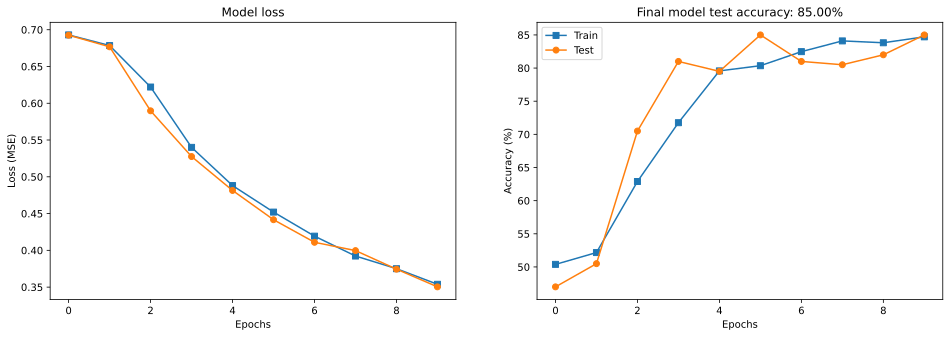

In [53]:
# show the results:

fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(testLoss,'o-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(testAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

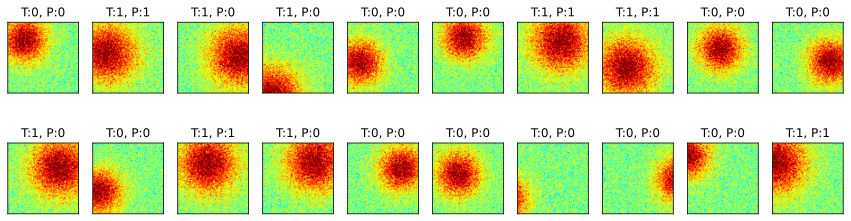

In [54]:
# visualize some images

X,y = next(iter(test_loader)) # extract X,y from test dataloader
yHat,featmap1,featmap2 = net(X)

fig,axs = plt.subplots(2,10,figsize=(15,4))

for i,ax in enumerate(axs.flatten()):
  G = torch.squeeze( X[i,0,:,:] ).detach()
  ax.imshow(G,vmin=-1,vmax=1,cmap='jet')
  t = ( int(y[i].item()) , int(yHat[i].item()>.5) )
  ax.set_title('T:%s, P:%s'%t)
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()

# Draw the feature maps:

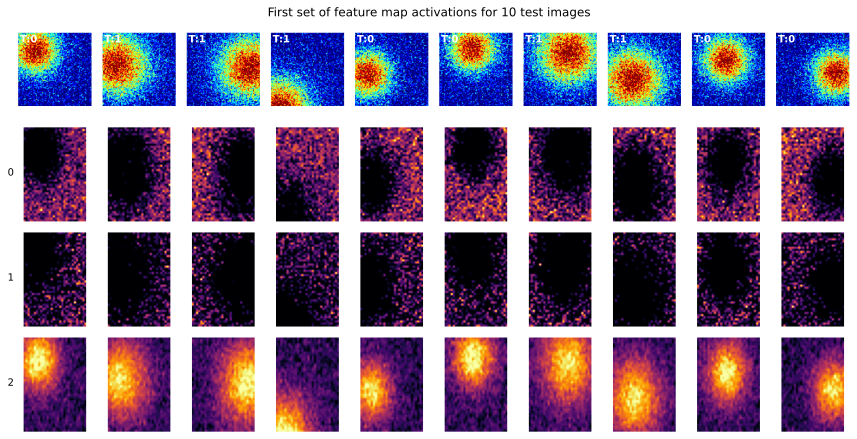

In [55]:
# Feature maps from the conv1 layer

fig,axs = plt.subplots(featmap1.shape[1]+1,10,figsize=(12,6))

for pici in range(10):

  # show the original picture
  img = X[pici,0,:,:].detach()
  axs[0,pici].imshow(img,cmap='jet',vmin=0,vmax=1)
  axs[0,pici].axis('off')
  axs[0,pici].text(2,2,'T:%s'%int(y[pici].item()),ha='left',va='top',color='w',fontweight='bold')

  for feati in range(featmap1.shape[1]):
      # extract the feature map from this image
      img = featmap1[pici,feati,:,:].detach()
      axs[feati+1,pici].imshow(img,cmap='inferno',vmin=0,vmax=torch.max(img)*.9)
      axs[feati+1,pici].axis('off')
      axs[feati+1,pici].text(-5,featmap1.shape[2]/2,feati,ha='right') if pici==0 else None

plt.tight_layout()
plt.suptitle('First set of feature map activations for 10 test images',x=.5,y=1.01)
plt.show()

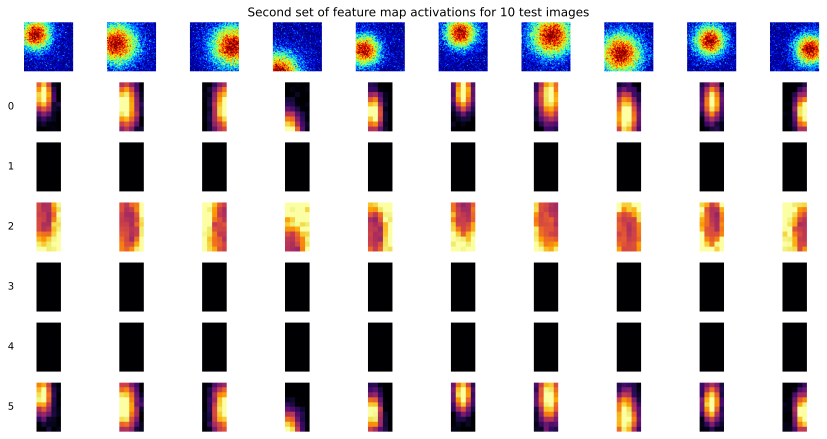

In [56]:
# Repeat for feature2 maps

fig,axs = plt.subplots(featmap2.shape[1]+1,10,figsize=(12,6))

for pici in range(10):

  # show the original picture
  img = X[pici,0,:,:].detach()
  axs[0,pici].imshow(img,cmap='jet',vmin=0,vmax=1)
  axs[0,pici].axis('off')

  for feati in range(featmap2.shape[1]):
      # extract the feature map from this image
      img = featmap2[pici,feati,:,:].detach()
      axs[feati+1,pici].imshow(img,cmap='inferno',vmin=0,vmax=torch.max(img)*.9)
      axs[feati+1,pici].axis('off')
      axs[feati+1,pici].text(-5,featmap2.shape[2]/2,feati,ha='right') if pici==0 else None

plt.tight_layout()
plt.suptitle('Second set of feature map activations for 10 test images',x=.5,y=1.01)
plt.show()

👆 There's a mismatch between the feature maps and the original images. The feature maps don't seem to really characterize what's actually happening in the original images very well.

# Spatial correlations across the feature maps:

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


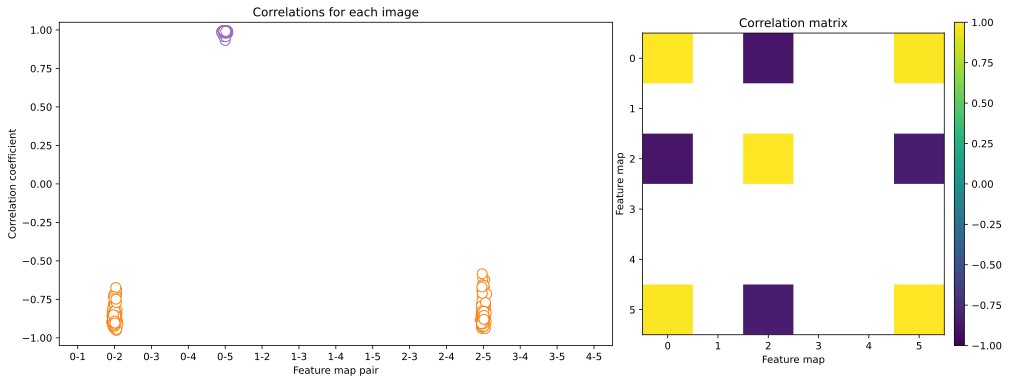

In [57]:
### correlations across the SECOND convolution layer

# convenient variables
nStim = featmap2.shape[0]
nMaps = featmap2.shape[1]
nCors = (nMaps*(nMaps-1))//2

# initialze the matrix of all correlation values
allrs = np.zeros((nStim,nCors))
Call  = np.zeros((nMaps,nMaps))

# loop over each stimulus
for i in range(nStim):

  # extract the vectorized feature maps from this image
  featmaps = featmap2[i,:,:,:].view(nMaps,-1).detach()

  # compute the correlation matrix
  C = np.corrcoef(featmaps)
  Call += C

  # extract the unique correlations from the matrix
  idx = np.nonzero(np.triu(C,1))
  allrs[i,:] = C[idx]


# define the x-axis labels
xlab = []*nCors
for i in range(nCors):
  xlab.append('%s-%s' %(idx[0][i],idx[1][i]))




# now visualize the correlations
fig = plt.figure(figsize=(14,5))
ax0 = fig.add_axes([.1,.1,.55,.9]) # [left, bottom, width, height]
ax1 = fig.add_axes([.68,.1,.3,.9])
cax = fig.add_axes([.99,.1,.01,.9])

for i in range(nCors):
  ax0.plot(i+np.random.randn(nStim)/30,allrs[:,i],'o',markerfacecolor='w',markersize=10)

# make the plot more interpretable
ax0.set_xlim([-.5,nCors-.5])
ax0.set_ylim([-1.05,1.05])
ax0.set_xticks(range(nCors))
ax0.set_xticklabels(xlab)
ax0.set_xlabel('Feature map pair')
ax0.set_ylabel('Correlation coefficient')
ax0.set_title('Correlations for each image')


# now show the average correlation matrix
h = ax1.imshow(Call/nStim,vmin=-1,vmax=1)
ax1.set_title('Correlation matrix')
ax1.set_xlabel('Feature map')
ax1.set_ylabel('Feature map')
# add a colorbar
fig.colorbar(h,cax=cax)

plt.show()

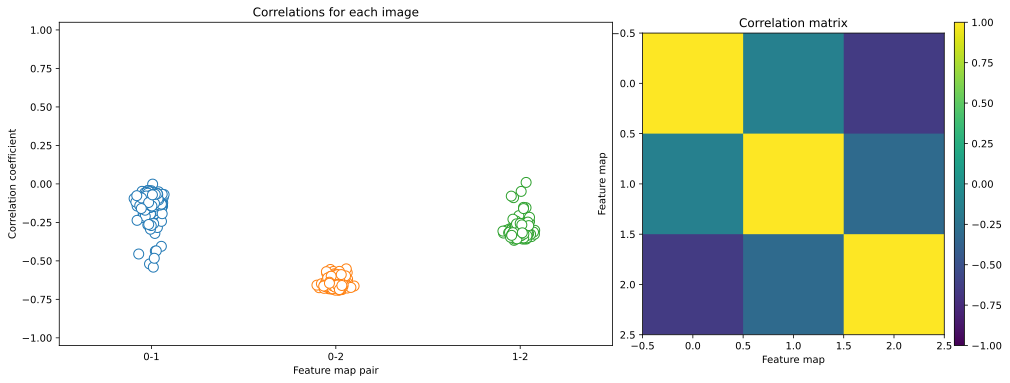

In [58]:
### correlations across the FIRST convolution layer

# convenient variables
nStim = featmap1.shape[0]
nMaps = featmap1.shape[1]
nCors = (nMaps*(nMaps-1))//2

# initialze the matrix of all correlation values
allrs = np.zeros((nStim,nCors))
Call  = np.zeros((nMaps,nMaps))

# loop over each stimulus
for i in range(nStim):

  # extract the vectorized feature maps from this image
  featmaps = featmap1[i,:,:,:].view(nMaps,-1).detach()

  # compute the correlation matrix
  C = np.corrcoef(featmaps)
  Call += C

  # extract the unique correlations from the matrix
  idx = np.nonzero(np.triu(C,1))
  allrs[i,:] = C[idx]


# define the x-axis labels
xlab = []*nCors
for i in range(nCors):
  xlab.append('%s-%s' %(idx[0][i],idx[1][i]))




# now visualize the correlations
fig = plt.figure(figsize=(14,5))
ax0 = fig.add_axes([.1,.1,.55,.9]) # [left, bottom, width, height]
ax1 = fig.add_axes([.68,.1,.3,.9])
cax = fig.add_axes([.99,.1,.01,.9])

for i in range(nCors):
  ax0.plot(i+np.random.randn(nStim)/30,allrs[:,i],'o',markerfacecolor='w',markersize=10)

# make the plot more interpretable
ax0.set_xlim([-.5,nCors-.5])
ax0.set_ylim([-1.05,1.05])
ax0.set_xticks(range(nCors))
ax0.set_xticklabels(xlab)
ax0.set_xlabel('Feature map pair')
ax0.set_ylabel('Correlation coefficient')
ax0.set_title('Correlations for each image')


# now show the average correlation matrix
h = ax1.imshow(Call/nStim,vmin=-1,vmax=1)
ax1.set_title('Correlation matrix')
ax1.set_xlabel('Feature map')
ax1.set_ylabel('Feature map')
# add a colorbar
fig.colorbar(h,cax=cax)

plt.show()